In [45]:

import torch
import random
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
import pycocotools.mask as mask_util
import os
from datasets.utils import blend_image_segmentation
from datasets.severstal_coco import DatasetCOCO
import cv2
import numpy as np
from skimage.transform import resize

# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();
#weights = '/home/eas/Enol/pycharm_projects/clipseg_steel_defect/logs/rd64-7K-vit16-cbh-coco-enol-5classes_no_neg/weights.pth'
weights = '/home/eas/Enol/pycharm_projects/clipseg_steel_defect/weights/rd64-uni-refined.pth'

COCO_CLASSES = {1: 'network of fine, hairline cracks or fissures on the surface of the steel',
                2: 'scale—oxides embedded into the steel plate',
                3: 'shallow, narrow grooves or lines on the surface of the steel',
                4: 'impurity or foreign material embedded within the steel matrix',
                5: 'defects on a steel plate'}
# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load(weights, map_location=torch.device('cpu')), strict=False);
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.34388125, 0.34388125, 0.34388125], std=[0.13965334, 0.13965334, 0.13965334]),
    transforms.Resize((352, 352))
])

/tmp/ipykernel_12233/1741836291.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights, map_location=torch.device('cpu')), strict=Fals

In [46]:
data_path = '/home/eas/Enol/pycharm_projects/clipseg_steel_defect/Severstal/train_subimages'
coco_dataset = DatasetCOCO(data_path, transform, 'val', True)
metadata = coco_dataset.img_metadata
query_class = 4
query_id = random.choice(coco_dataset.ids_by_class[query_class])
query = metadata.loadAnns(ids=query_id)[0]
query_image = Image.open(os.path.join(data_path, query['image_id'])).convert('RGB')
query_label = COCO_CLASSES[query_class]
query_mask = mask_util.decode(query['segmentation'])


support_class = 4
support_id = random.choice(coco_dataset.ids_by_class[support_class])
support = metadata.loadAnns(ids=support_id)[0]
support_image = Image.open(os.path.join(data_path, support['image_id'])).convert('RGB')
support_label = COCO_CLASSES[support_class]
support_mask = mask_util.decode(support['segmentation'])

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [47]:
query_image_bounded = np.array(query_image, np.uint8)
contours, hierarchy = cv2.findContours(query_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
for i, contour in enumerate(contours):
    cv2.drawContours(query_image_bounded, contour, -1, (0, 0, 255), 2)
query_image_bounded = resize(query_image_bounded, (352, 352))

In [48]:
q = transform(query_image).unsqueeze(0)
s = transform(support_image)
support_mask = resize(support_mask, (352,352), preserve_range=True)
support_mask = (support_mask >= 0.5).astype(np.uint8)
query_mask = resize(query_mask, (352,352), preserve_range=True)
query_mask = (query_mask >= 0.5).astype(np.uint8)

#s_blend = blend_image_segmentation(s, support_mask, mode='blur3_highlight01', image_size=256)
s_blend = blend_image_segmentation(s, support_mask, mode='crop_blur_highlight352', image_size=352)

s_tensor = torch.Tensor(s_blend[0]).unsqueeze(0)

In [49]:
text_cond = model.compute_conditional([support_label])
visual_s_cond, _, _ = model.visual_forward(s_tensor)
cond_zero_shot = text_cond 
cond_one_shot = visual_s_cond 

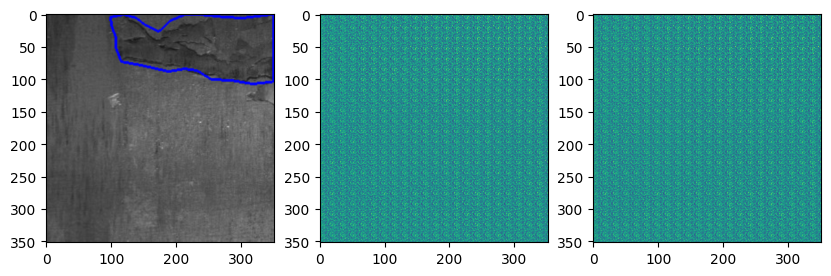

In [50]:

# predict
with torch.no_grad():
    preds_zero_shot = model(q, cond_zero_shot)[0].squeeze(0).squeeze(0)
    prob_map_zero_shot = np.array(torch.sigmoid(preds_zero_shot))
    prob_map_8bits_zero_shot = (prob_map_zero_shot*255).astype(np.uint8)
    """
    preds_one_shot = model(q, cond_one_shot)[0].squeeze(0).squeeze(0)
    prob_map_one_shot = np.array(torch.sigmoid(preds_one_shot))
    prob_map_8bits_one_shot = (prob_map_one_shot*255).astype(np.uint8)
    """
    
# visualize prediction


_, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(query_image_bounded)
ax[1].imshow(prob_map_zero_shot)
ax[2].imshow(prob_map_zero_shot)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6125425..4.698196].


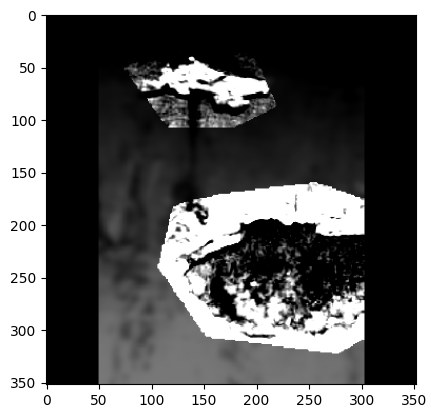

In [51]:
plt.imshow(s_blend[0].transpose(1,2,0))